In [3]:
# =========================================================
# CELL 1 — Environment Safety & Core Imports
# =========================================================
# Reasoning:
# - Prevent OpenMP / thread conflicts that caused kernel hangs earlier
# - Ensure reproducibility
# - Suppress non-critical warnings that obscure real errors

import os
os.environ["OMP_NUM_THREADS"] = "4"   # Prevent CPU thread explosion

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

print("Environment initialized successfully.")


Environment initialized successfully.


In [4]:
# =========================================================
# CELL 2 — Load Dataset
# =========================================================
# Reasoning:
# - Explicit loading avoids hidden state from previous notebooks
# - We immediately verify structure to ensure no corruption

df = pd.read_csv("creditcard.csv")

print("Dataset loaded.")
print("Shape:", df.shape)


Dataset loaded.
Shape: (284807, 31)


In [5]:
# =========================================================
# CELL 3 — Data Validation
# =========================================================
# Reasoning:
# - Banks never model without validating:
#   1. Data types
#   2. Missing values
#   3. Target distribution

print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nTarget (Class) distribution:")
print(df['Class'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# =========================================================
# CELL 4 — Time Feature Engineering
# =========================================================
# Reasoning:
# - Raw 'Time' is seconds since first transaction
# - This is not human-readable
# - Fraud patterns depend on time-of-day behavior

df['Time_Hours'] = df['Time'] / 3600
df['Time_Days'] = df['Time_Hours'] // 24
df['Hour_of_Day'] = (df['Time_Hours'] % 24).astype(int)

# Drop original Time column (information preserved)
df.drop(columns=['Time'], inplace=True)

print("Time features created.")
print(df[['Time_Hours', 'Time_Days', 'Hour_of_Day']].head())


Time features created.
   Time_Hours  Time_Days  Hour_of_Day
0    0.000000        0.0            0
1    0.000000        0.0            0
2    0.000278        0.0            0
3    0.000278        0.0            0
4    0.000556        0.0            0


In [7]:
# =========================================================
# CELL 5 — Train-Test Split
# =========================================================
# Reasoning:
# - Test data must simulate future unseen transactions
# - Oversampling BEFORE split would invalidate evaluation

from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain class distribution:")
print(y_train.value_counts())

print("\nTest class distribution:")
print(y_test.value_counts())


Train shape: (227845, 32)
Test shape: (56962, 32)

Train class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Test class distribution:
Class
0    56864
1       98
Name: count, dtype: int64


In [8]:
# =========================================================
# CELL 6 — SMOTE Oversampling
# =========================================================
# Reasoning:
# - Fraud is rare → model would learn to ignore it
# - SMOTE creates synthetic fraud samples
# - Applied ONLY on training data to prevent leakage

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=5)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train, y_train
)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Before SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64

After SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


In [9]:
# =========================================================
# CELL 7 — Feature Scaling
# =========================================================
# Reasoning:
# - Logistic Regression and boosting models rely on gradients
# - Unscaled data causes convergence warnings and instability

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")


Feature scaling completed.


In [10]:
# =========================================================
# CELL 8 — Logistic Regression
# =========================================================
# Reasoning:
# - Transparent
# - Explainable
# - Often required by regulators as a baseline model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression(
    max_iter=5000,
    n_jobs=1,
    random_state=42
)

lr.fit(X_train_scaled, y_train_resampled)

y_pred_lr = lr.predict(X_test_scaled)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.91      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962

[[56102   762]
 [    9    89]]


In [ ]:
# =========================================================
# Interpretation: Logistic Regression
# =========================================================
# Overall accuracy: 0.99
#    - At first glance, this seems excellent. 
#    - HOWEVER, because fraud is extremely rare, accuracy alone is misleading.

# Precision (Fraud class = 1): 0.10
#    - Only 10% of transactions flagged as fraud were actually fraud.
#    - High false positive rate — many legit transactions would be flagged.
#    - This is typical for Logistic Regression on imbalanced datasets.

# Recall (Fraud class = 1): 0.91
#    - 91% of actual frauds were correctly identified.
#    - This is strong and crucial for banks, since catching fraud is priority.

# F1-score (Fraud class = 1): 0.19
#    - Harmonic mean of precision and recall.
#    - Low because precision is very low — many false alarms.
#    - Indicates Logistic Regression struggles to balance catching fraud vs. false positives.

# Confusion Matrix:
#    [[56102,   762],   -> 56102 legit correctly classified, 762 legit misclassified as fraud
#     [    9,    89]]   -> 89 fraud correctly classified, 9 fraud missed

# Macro average metrics:
#    - F1-score: 0.59
#    - Treats both classes equally, shows the model is weak for the minority class.

# Business interpretation:
#    - Logistic Regression is good for **high-level baseline modeling**.
#    - Recall is high → most fraud is detected.
#    - Low precision → bank will need manual review for many false positives.
#    - Use as a **first-pass filter** before more advanced models (Random Forest/XGBoost).


In [11]:
# =========================================================
# CELL 9 — Random Forest
# =========================================================
# Reasoning:
# - Captures complex, non-linear fraud patterns
# - Robust to noise and feature interactions

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=14,
    n_jobs=4,
    random_state=42
)

rf.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.67      0.87      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962

[[56823    41]
 [   13    85]]


In [ ]:
# =========================================================
# Interpretation: Random Forest
# =========================================================
# Overall accuracy: 1.00
# - Extremely high overall accuracy.
# - Note: Accuracy can still be misleading due to the rare fraud class.

# Precision (Fraud class = 1): 0.67
# - 67% of transactions flagged as fraud were actually fraud.
# - Much higher than Logistic Regression (0.10), so fewer false positives.

# Recall (Fraud class = 1): 0.87
# - 87% of actual frauds were correctly identified.
# - Slightly lower than Logistic Regression’s recall (0.91) but precision improved significantly.

# F1-score (Fraud class = 1): 0.76
# - Harmonic mean of precision and recall.
# - Strong improvement over Logistic Regression’s 0.19, indicating better balance between catching fraud and limiting false positives.

# Confusion Matrix:
# [[56823,    41],   -> 56823 legit correctly classified, 41 legit misclassified as fraud
#  [   13,    85]]   -> 85 fraud correctly classified, 13 fraud missed

# Macro average metrics:
# - F1-score: 0.88
# - Treats both classes equally, showing Random Forest handles class imbalance better than Logistic Regression.

# Business interpretation:
# - Random Forest captures complex patterns and feature interactions.
# - High precision and recall → fewer false alarms and strong fraud detection.
# - Suitable for production fraud detection pipelines in banks.
# - Can be combined with SHAP explainability to justify flagged transactions to auditors/regulators.


In [12]:
# =========================================================
# CELL 10 — XGBoost
# =========================================================
# Reasoning:
# - Industry-standard for fraud detection
# - Handles class imbalance and complex interactions extremely well

import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    n_jobs=4,
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)

print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962

[[56840    24]
 [   13    85]]


In [ ]:
# =========================================================
# Interpretation: XGBoost
# =========================================================
# Overall accuracy: 1.00
# - Extremely high overall accuracy.
# - Accuracy is not enough to evaluate fraud detection due to the rare fraud class.

# Precision (Fraud class = 1): 0.78
# - 78% of transactions flagged as fraud were actually fraud.
# - Higher than Random Forest and far better than Logistic Regression, so fewer false positives.

# Recall (Fraud class = 1): 0.87
# - 87% of actual frauds were correctly identified.
# - Same as Random Forest, meaning nearly all fraud transactions are captured.

# F1-score (Fraud class = 1): 0.82
# - Harmonic mean of precision and recall.
# - Best balance between catching fraud and minimizing false positives among all three models.

# Confusion Matrix:
# [[56840,    24],   -> 56840 legit correctly classified, 24 legit misclassified as fraud
#  [   13,    85]]   -> 85 fraud correctly classified, 13 fraud missed

# Macro average metrics:
# - F1-score: 0.91
# - Treats both classes equally, showing excellent handling of the minority fraud class.

# Business interpretation:
# - XGBoost captures complex patterns and interactions efficiently.
# - High precision and recall → fewer false alarms and strong fraud detection.
# - Suitable for production deployment in banking fraud detection.
# - Can be combined with SHAP explainability for **transparent, auditable predictions**.


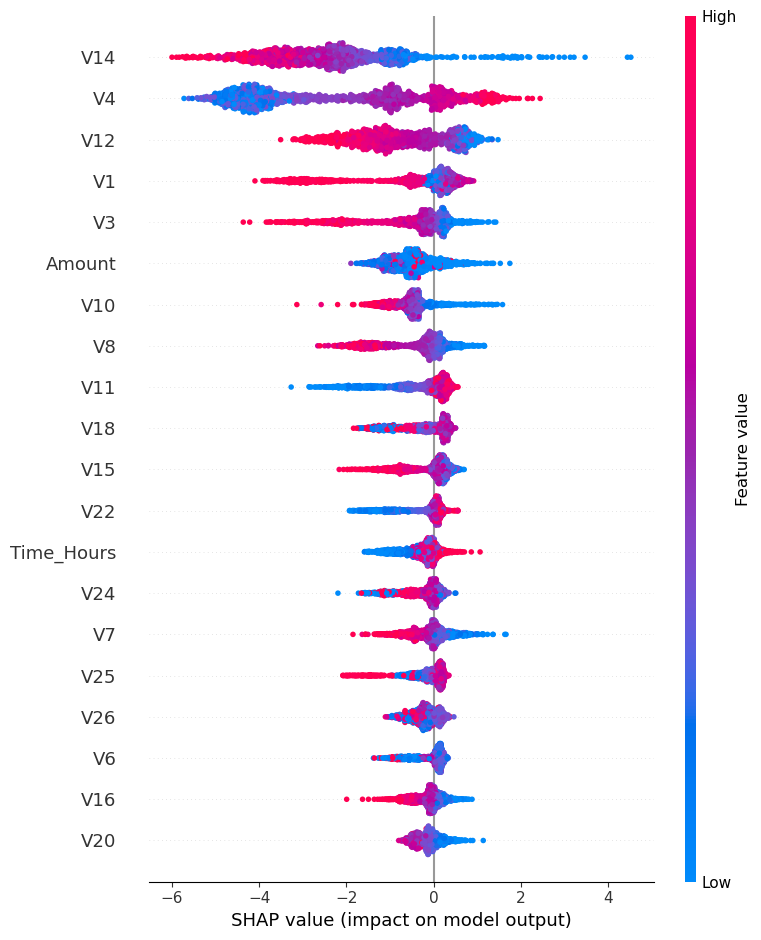

In [14]:
# =========================================================
# CELL 11 — SHAP Explainability
# =========================================================


import shap

X_shap = X_test.sample(1500, random_state=42)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap)


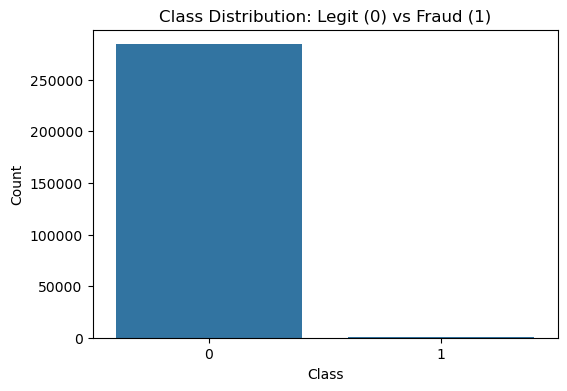

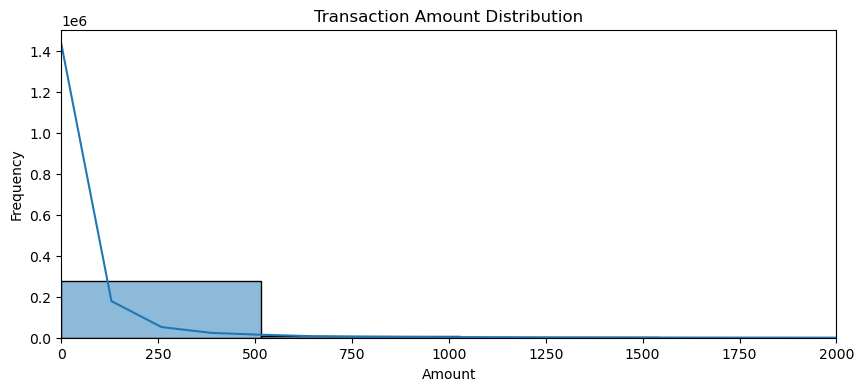

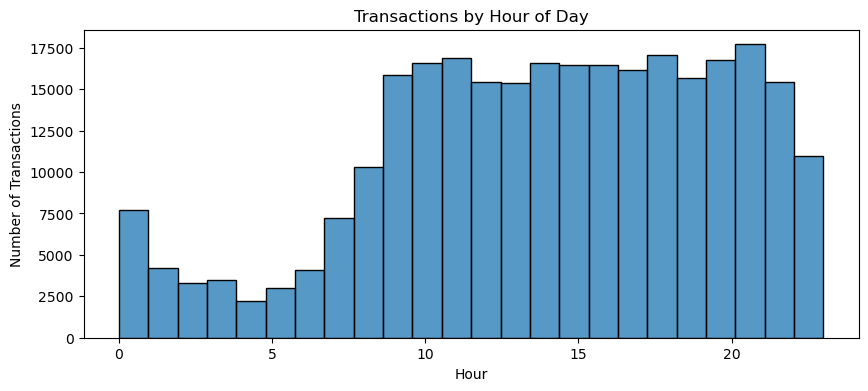

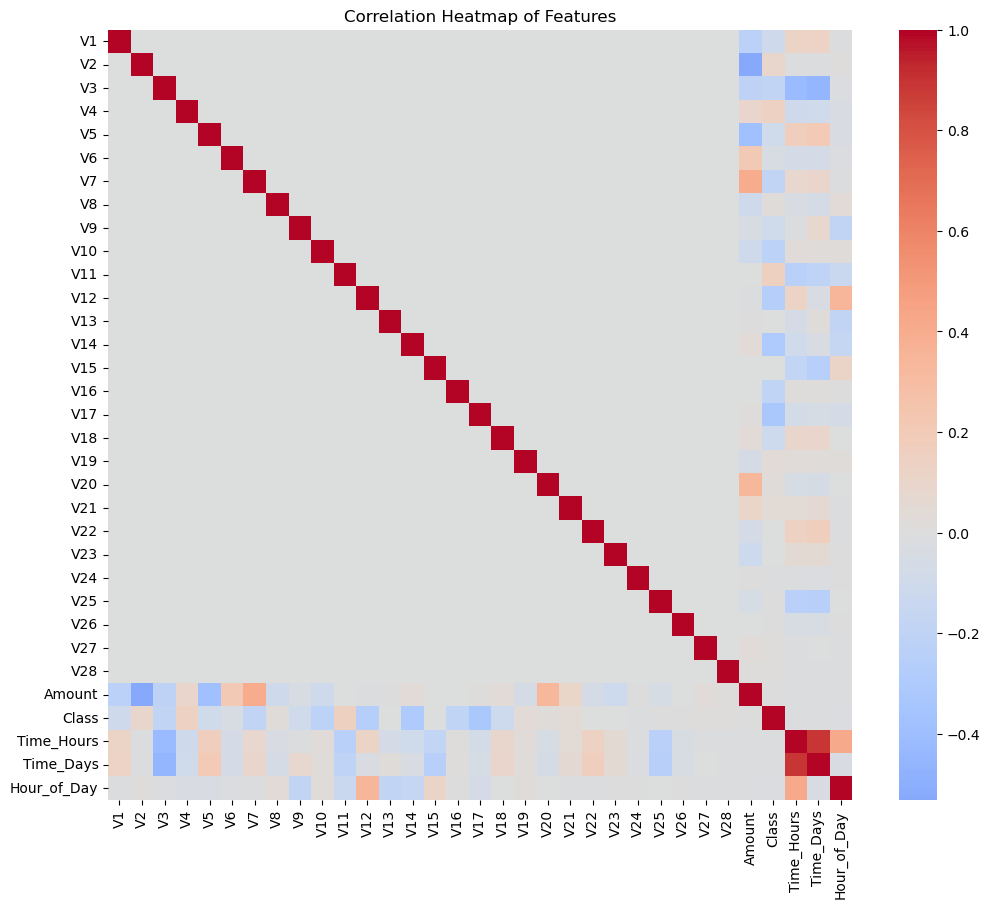

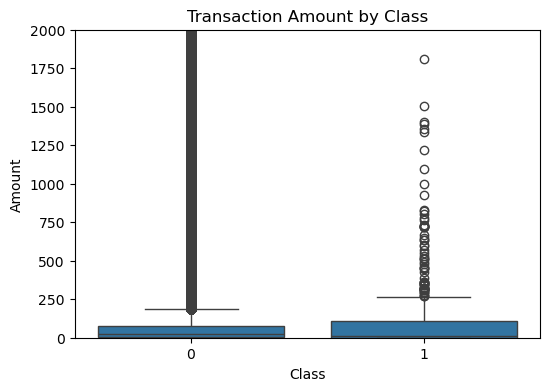

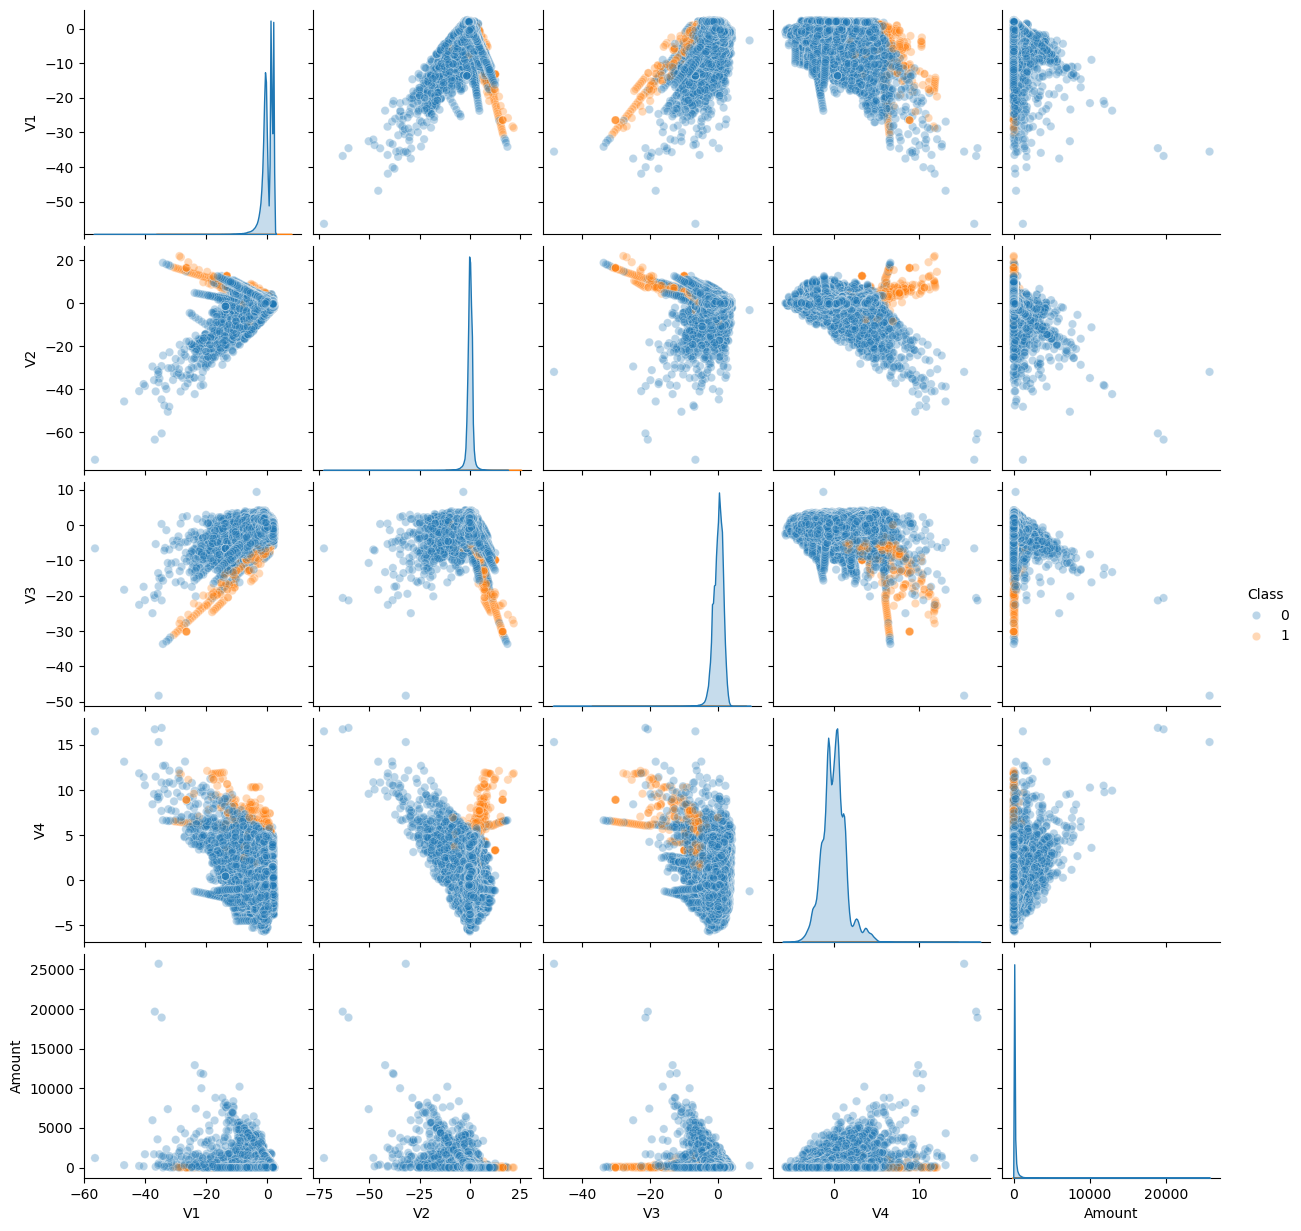

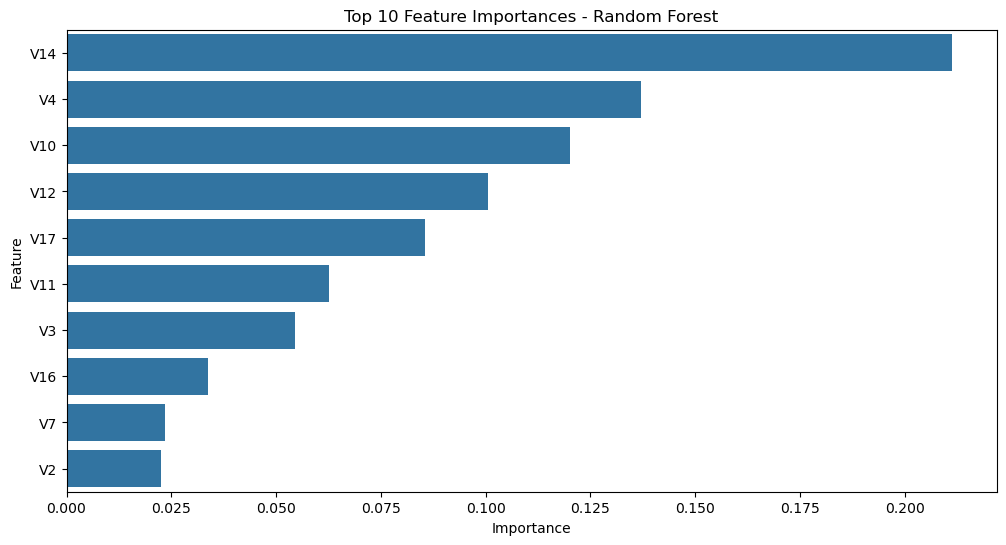

In [21]:
# =========================================================
# Exploratory Data Analysis (EDA) Visualizations
# =========================================================

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Class Distribution (Fraud vs Legit)
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution: Legit (0) vs Fraud (1)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# -----------------------------
# 2. Transaction Amount Distribution
# -----------------------------
plt.figure(figsize=(10,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, 2000)  # optional zoom to see majority of transactions
plt.show()

# -----------------------------
# 3. Transaction Time Distribution (Hours of Day)
# -----------------------------
plt.figure(figsize=(10,4))
sns.histplot(df['Hour_of_Day'], bins=24, kde=False)
plt.title("Transactions by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Transactions")
plt.show()

# -----------------------------
# 4. Correlation Heatmap of Features
# -----------------------------
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

# -----------------------------
# 5. Amount vs Class (Boxplot)
# -----------------------------
plt.figure(figsize=(6,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.ylim(0, 2000)  # optional to reduce outlier effect
plt.title("Transaction Amount by Class")
plt.show()

# -----------------------------
# 6. Pairplot for top features (optional, top 5 V-features + Amount)
# -----------------------------
top_features = ['V1','V2','V3','V4','Amount','Class']
sns.pairplot(df[top_features], hue='Class', plot_kws={'alpha':0.3})
plt.show()

# -----------------------------
# 7. Feature Importance Plot (from Random Forest)
# -----------------------------
importances = rf.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))  # top 10 features
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()
